# MASH Prediction By Logistic Regression
Author: Nana K. Owusu

Purpose: To determine if the 95% confidence interval level for the
attenuation vs. shear stiffness predictors of the logistic regression models.

### Initial libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import import_module, reload
from timeit import default_timer as timer
%matplotlib inline

In [21]:
from sys import path
path.append('/Users/nowusu/GitHub_repos/ml_portfolio/MASLD_prediction/')

import ml_lib
ml_lib = reload(ml_lib)
from ml_lib import (roc_plot, classification_metrics, LOO_testing, calc_auc, DeLong2_test,
                   export_as_excel)

### Getting and Cleaning the Data

In [3]:
data=pd.read_csv('/Users/nowusu/GitHub_repos/ml_portfolio/MASLD_prediction/NAFLD-four-cohorts_20220413.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cohort        510 non-null    object 
 1   ID            510 non-null    object 
 2   Steatosis     487 non-null    float64
 3   Inflammation  399 non-null    float64
 4   Ballooning    469 non-null    float64
 5   Fibrosis      496 non-null    float64
 6   NAS           466 non-null    float64
 7   NASH          488 non-null    object 
 8   NASH(0-2)     399 non-null    float64
 9   NASH-F2       399 non-null    float64
 10  NASH(0-1)     488 non-null    float64
 11  PDFF          504 non-null    float64
 12  LS-2D-60      499 non-null    float64
 13  LS-3D-60      396 non-null    float64
 14  DR-3D-60      396 non-null    float64
 15  SM-3D-60      396 non-null    float64
 16  LM-3D-60      396 non-null    float64
 17  LS-3D-40      386 non-null    float64
 18  DR-3D-40      386 non-null    

In [4]:
#SELECTING RELEVANT COLUMNS
cols_3Dmre = ['Steatosis','Inflammation','Ballooning',
              'NASH(0-1)','Fibrosis','PDFF',
              'LS-3D-60','DR-3D-60','SM-3D-60', 'LM-3D-60']
data=data[cols_3Dmre]

data.dropna(inplace=True)

#ADDING TARGET COLUMNS
# create categorcial column for fibrosis grade greater than 1
data['Fib_gt1'] = data['Fibrosis'].apply(lambda x: int(x>1))
# create categorical column for patients with high-risk MASH,
# (HRM = MASH ^ Fib_gt1)
data['HRM'] = data['NASH(0-1)'].astype('int16') & data['Fib_gt1']

data.rename({'LS-3D-60':'SS','DR-3D-60':'DR',
            'SM-3D-60':'SM','LM-3D-60':'LM',
            'NASH(0-1)':'MASH_gt0'},axis=1, inplace=True)

#RESETTING INDEX
data.reset_index(drop=True, inplace=True)

#### Export cleaned data to excel

In [5]:
#SUMMARY
print('\nDATA TYPES:\n-----------')
print(data.dtypes)
print('\nMISSING VALUES:\n---------------')
print(data.isna().sum())
print('\nDIMENSIONS:\n---------------')
print(data.shape)
data.head()


DATA TYPES:
-----------
Steatosis       float64
Inflammation    float64
Ballooning      float64
MASH_gt0        float64
Fibrosis        float64
PDFF            float64
SS              float64
DR              float64
SM              float64
LM              float64
Fib_gt1           int64
HRM               int64
dtype: object

MISSING VALUES:
---------------
Steatosis       0
Inflammation    0
Ballooning      0
MASH_gt0        0
Fibrosis        0
PDFF            0
SS              0
DR              0
SM              0
LM              0
Fib_gt1         0
HRM             0
dtype: int64

DIMENSIONS:
---------------
(379, 12)


,Steatosis,Inflammation,Ballooning,MASH_gt0,Fibrosis,PDFF,SS,DR,SM,LM,Fib_gt1,HRM
0,2.0,2.0,1.0,1.0,0.0,15.58,1.982085,0.093943,1.948,0.366,0,0
1,2.0,2.0,1.0,1.0,1.0,28.99,2.449648,0.075764,2.422,0.367,0,0
2,2.0,2.0,1.0,1.0,0.5,11.71,2.780881,0.064540,2.758,0.356,0,0
3,1.0,1.0,1.0,1.0,2.0,10.64,2.482754,0.036955,2.476,0.183,1,1
4,1.0,1.0,1.0,1.0,0.5,4.69,3.172105,0.040006,3.162,0.253,0,0


### Machine Learning
#### Initialization

In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.contingency_tables import mcnemar

In [7]:
#DEFINING GLOBAL ML PARAMETERS
Cs = np.logspace(-4,4,9)
cv = LeaveOneOut()
scoring = 'accuracy'
solver = 'liblinear'
tol = 1e-6
max_iter = int(1e6)
class_weight = 'balanced'

#DEFINING TARGETS
# HRM is high-risk MASH a designation for those with positive MASH diagnosis by biopsy,
# concomitant with fibrosis at stage 2 or above
# MASH_gt0 is the positive diagnosis for metabolic dysfunction associated steatotic
# liver disease via liver biopsy.
targets = ['HRM']#,'MASH_gt0']

#DEFINING MODELS
models = {'SS':['SS'],
          'FF':['PDFF'],
          'SSFFDR':['SS','PDFF','DR']}

#DEFINING METRICS DATAFRAME
metric_cols=['target','model','AUC','AUC_L','AUC_U','TP','FP','TN','FN',
             'sens','sens_L','sens_U','spec','spec_L','spec_U','NPV',
             'NPV_L','NPV_U','PPV','PPV_L','PPV_U']
metric_cols=metric_cols+[f"MN_p_{model}" for model in models.keys()]+[f"DL_p_{model}" for model in models.keys()]
metrics=pd.DataFrame(columns=metric_cols)

#MODEL PARAM STORAGE
# model_coefs = {target:{model:[] for model in models} for target in targets}
# model_intercepts = {target:{model:[] for model in models} for target in targets}

#### Bootstrapped Training, Validation, and Testing

In [ ]:
#TESTING PERFORMANCE OF EACH MODEL
#Initialization
alpha=0.05
start = timer()
#Looping Over Models and Targets
for target in targets:
    for model in models:
        #Initializing Logistic Regression Model
        clf=LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver, \
                                 tol=tol,max_iter=max_iter,class_weight=class_weight)
        
        #Defining Features and Target
        X=data[models[model]]
        Y=data[target]
        
        #Defining Output Columns
        data[target+'_'+model+'_proba']=np.nan
        data[target+'_'+model+'_pred']=np.nan
        
        #Computing Test Predictions With Bootstrap
        LOO_testing(data, target, model, X, Y, clf)
        
        #Test AUC
        AUC_L, AUC, AUC_U = calc_auc(data, Y, data[target+'_'+model+'_proba'], alpha)
        
        #Test Classification Metrics
        cmatrix_dict = classification_metrics(data, Y, data[target+'_'+model+'_pred'], 
                                              alpha)
        
        #Storing Results
        new_row={'target':target,'model':model,
                 'AUC':AUC,'AUC_L':AUC_L,'AUC_U':AUC_U}
        new_row.update(cmatrix_dict)
        metrics = pd.concat([metrics, pd.DataFrame([new_row])], ignore_index=True)
        
end = timer()
#SAVING RESULTS
# outname = '4_cohorts/fibrosis_detection_test.xlsx'
# outname = './masld_prediction_test.xlsx'
# export_as_excel(outname, 'w', [data], 'mre_60Hz', False)

mins, secs = divmod(end - start, 60)
hrs, mins = divmod(mins, 60)
print(f'elapsed time: {hrs} hr {mins} min {round(secs, 2)} sec')

/var/folders/k9/2h69mqhn6zg5qg90v8137ldc0000gn/T/ipykernel_79828/1597859427.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame([new_row])], ignore_index=True)


elapsed time: 0.0 hr 27.0 min 35.58 sec


### Evaluation
#### Exact McNemar Test of Sensitivities

In [13]:
for model1 in models:
    k=0
    for target in targets:
        for model2 in models:
            #Labeling Positive Cohort Predictions Correct/Incorrect
            TP1=data[target+'_'+model1+'_pred'][data[target]==1]
            TP2=data[target+'_'+model2+'_pred'][data[target]==1]
            ctable=np.array([[((TP1==1)&(TP2==1)).sum(),((TP1==1)&(TP2==0)).sum()],\
                             [((TP1==0)&(TP2==1)).sum(),((TP1==0)&(TP2==0)).sum()]])
            
            #Different Models
            if model1!=model2:
                metrics.loc[k,'MN_p_'+model1]=mcnemar(ctable,exact=True).pvalue
            
            #Same Model
            else:
                metrics.loc[k,'MN_p_'+model1]=np.nan
            
            #Row Iterator
            k+=1

In [14]:
metrics

,target,model,AUC,AUC_L,AUC_U,TP,FP,TN,FN,sens,...,NPV_U,PPV,PPV_L,PPV_U,MN_p_SS,MN_p_FF,MN_p_SSFFDR,DL_p_SS,DL_p_FF,DL_p_SSFFDR
0,HRM,SS,0.860825,0.809638,0.912011,58,42,249,30,0.659091,...,0.926267,0.580000,0.477119,0.678014,NaN,0.029305,0.607239,NaN,NaN,NaN
1,HRM,FF,0.579663,0.509897,0.649428,42,118,173,46,0.477273,...,0.841925,0.262500,0.196197,0.337820,0.029305,NaN,0.003378,NaN,NaN,NaN
2,HRM,SSFFDR,0.853561,0.801301,0.905822,61,55,236,27,0.693182,...,0.931248,0.525862,0.431055,0.619317,0.607239,0.003378,NaN,NaN,NaN,NaN


#### Delong Test of AUCs

In [15]:
#DELONG TESTS OF AUC
for model1 in models:
    k=0
    for target in targets:
        for model2 in models:
            #Different Models
            if model1!=model2:
                X1=np.array((data[target+'_'+model1+'_proba'])[data[target]==1])
                Y1=np.array((data[target+'_'+model1+'_proba'])[data[target]==0])
                X2=np.array((data[target+'_'+model2+'_proba'])[data[target]==1])
                Y2=np.array((data[target+'_'+model2+'_proba'])[data[target]==0])
                metrics.loc[k,'DL_p_'+model1] = DeLong2_test(X1,Y1,X2,Y2)[1]
                
            #Same Model
            else:
                metrics.loc[k,'DL_p_'+model1]=np.nan
                
            #Row Iterator
            k+=1
                
#SAVING RESULTS
# metrics.to_excel('3_cohorts/LRM_test.xlsx',index=False)
# metrics.to_excel('4_cohorts/LRM_test.xlsx',index=False)

# outname = 'nash/LRM_nash_test.xlsx'
# export_as_excel(outname, 'w', [metrics], 'mre_60Hz', False)

In [16]:
metrics.head(5)
# metrics[['target','model','MN_p_S','MN_p_A','DL_p_S','DL_p_A']]

,target,model,AUC,AUC_L,AUC_U,TP,FP,TN,FN,sens,...,NPV_U,PPV,PPV_L,PPV_U,MN_p_SS,MN_p_FF,MN_p_SSFFDR,DL_p_SS,DL_p_FF,DL_p_SSFFDR
0,HRM,SS,0.860825,0.809638,0.912011,58,42,249,30,0.659091,...,0.926267,0.580000,0.477119,0.678014,NaN,0.029305,0.607239,NaN,0.0,0.293887
1,HRM,FF,0.579663,0.509897,0.649428,42,118,173,46,0.477273,...,0.841925,0.262500,0.196197,0.337820,0.029305,NaN,0.003378,0.0,NaN,0.0
2,HRM,SSFFDR,0.853561,0.801301,0.905822,61,55,236,27,0.693182,...,0.931248,0.525862,0.431055,0.619317,0.607239,0.003378,NaN,0.293887,0.0,NaN


#### ROC Curves

In [ ]:
# def roc_plot(fig, data, target_list, model, title):
#     for target in target_list:
#         y_true = data[target]
#         y_prob = data[target + '_' + model + '_proba']
#         # False-Positive rate (FPR),
#         # True-Positive rate (TPR), and threshold of
#         # the ROC curve. thresholds
#         FPR,TPR,_ = roc_curve(y_true,y_prob)
        
#         # Area under the Receiver-Operating
#         # Characteristic (ROC) curve.
#         AUC = roc_auc_score(y_true,y_prob)
        
#         # Plotting
#         ax_range=[0.0,1.0]
#         roc_range = np.linspace(0.0, 1.0, 10)
#         tenths=[n*0.1 for n in range(11)]
        
#         fig.axes.append(
#             plt.plot(FPR,TPR,label=f'{target}; AUC={AUC.round(3)}',linewidth=4)
#         )
        
#     fig.axes.append(
#         plt.plot(roc_range, roc_range, color='k', linestyle='dotted'))
#     fig.axes[0].set_xlabel('1-Specificity', fontsize=16)
#     fig.axes[0].set_ylabel('Sensitivity', fontsize=16)
#     fig.axes[0].grid(visible=True, which='both')
#     fig.axes[0].set_xticks(tenths)
#     fig.axes[0].set_yticks(tenths)
#     fig.axes[0].set_xlim(ax_range)
#     fig.axes[0].set_ylim(ax_range)
        
#     plt.legend(loc='lower right', fontsize=16)
#     fig.suptitle(title, fontsize=18)
#     fig.tight_layout()

In [23]:
targets[:1]

['HRM']

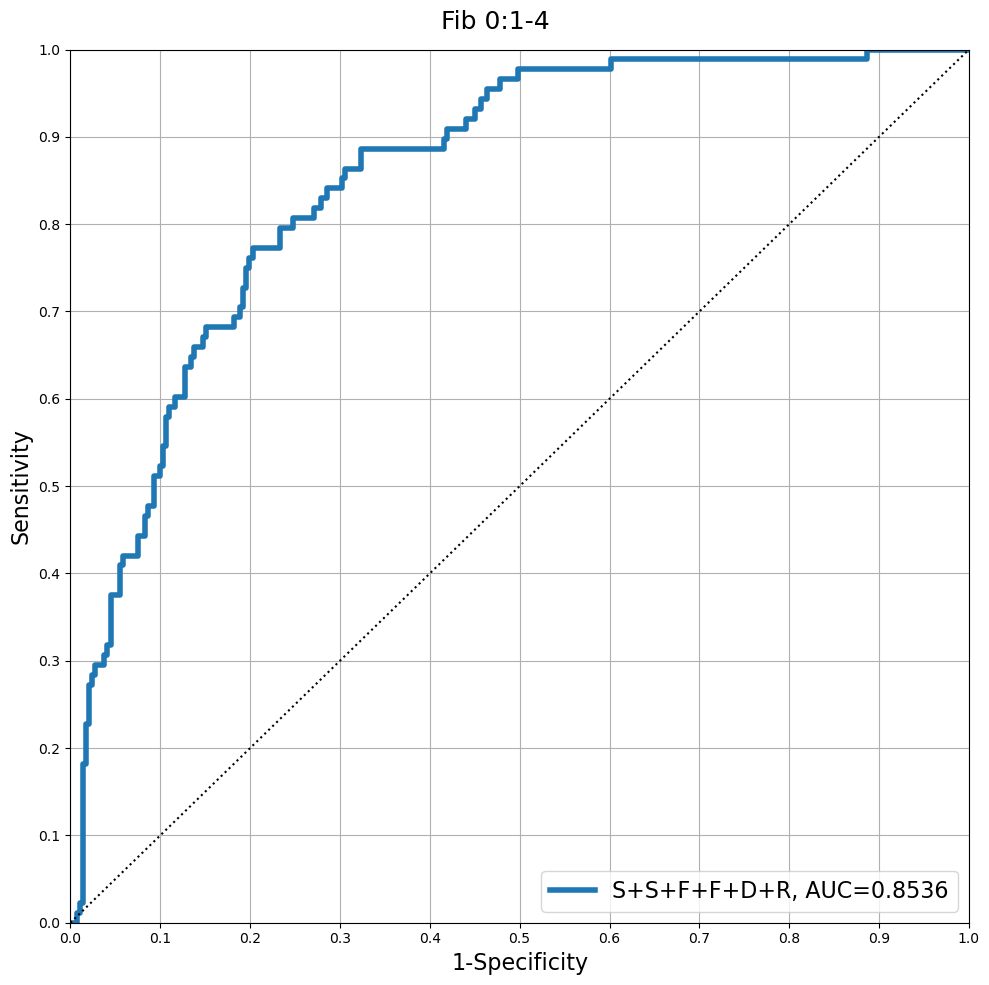

In [ ]:
# _ = data.drop(columns=['NAS_gt7_SSFFDR_proba','NAS_gt7_SSFFDR_pred'],inplace=True)
nas_fig = plt.figure(figsize=(10,10))
nas_fig.add_subplot()
roc_plot(nas_fig,data,'HRM',['SS','FF','SSFFDR'],'Fib 0:1-4')
# nas_fig.savefig('./nas_prediction_test.svg', format='svg')

In [ ]:
fibinf_fig.legend()

In [ ]:
best={'Fib_gt1':['SS','FF','SSFF','SSFFDR']}
models={'SS':['mu_SS'],
        'FF':['PDFF'],
        'SSFF':['mu_DR','PDFF'],
        'SSFFDR':['SS','PDFF','DR']}

fibinf_fig = plt.figure(figsize=(10,10))
fibinf_fig.add_subplot()
roc_plot(fibinf_fig,data1,'Fib_gt1',best['Fib_gt1'],models,'F>1')
# nas_fig.savefig('./nas_prediction_test.svg', format='svg')

In [ ]:
fibinf_fig.savefig('./fibrosis/fibgt1.svg', format='svg', bbox_inches=[])
# fibinf_fig.savefig('./fibrosis/fib_infl.svg', format='svg', bbox_inches=[])

In [ ]:
#BEST MODELS
# best = {'Fib_gt0':['S','SP']}#, 'SPR','APR']}
best={'Fib_gt0':['SP','SPD','SPGr','SGrDP','SPDGdGr'], 
      'Fib_gt1':['GdD','GrP','GrD','SGdD','SPDGdGr'],
      'Fib_gt2':['SPD','SPGr','SGdD','GdGrDP'],
      'Fib_gt3':['GrD','SPD','SGdD','SGrD','GdGrD']}

In [ ]:
#Fib_le0 ROC CURVES
fible0 = plt.figure(figsize=(10,10))
fible0.add_subplot()
roc_plot(fible0,data,'Fib_gt0',best['Fib_gt0'],models,'Fib 0:1-4')
# fible0.legend()

#SAVING PLOTS
# fible0.savefig('results_woUCSD/ROCs_test_Fib_le0.tiff', format='tiff')
# fible0.savefig('results_woUCSD/ROCs_test_Fib_gt0.svg', format='svg')
# fible0.savefig('results_woUCSD/ROCs_test_Fib_gt0.png', format='png')

In [ ]:
#Fib_le1 ROC CURVES
fible1 = plt.figure(figsize=(10,10))
fible1.add_subplot()
roc_plot(fible1,data,'Fib_gt1',best['Fib_gt1'],models,'Fib 0-1:2-4')

#SAVING PLOTS
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.eps', format='eps')
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.svg', format='svg')
# fible1.savefig('results_woUCSD/ROCs_test_Fib_le1.png', format='png')

In [ ]:
#s1 ROC CURVES
fible2 = plt.figure(figsize=(10,10))
fible2.add_subplot()
roc_plot(fible2,data,'Fib_gt2',best['Fib_gt2'],models,'Fib 0-2:3-4')

#SAVING PLOTS
# fible2.savefig('results_woUCSD/ROCs_test_Fib_le2.eps', format='eps')
# fible2.savefig('results_woUCSD/ROCs_test_Fib_gt2.svg', format='svg')
# fible2.savefig('results_woUCSD/ROCs_test_Fib_gt2.png', format='png')

In [ ]:
#s2 ROC CURVES
fible3 = plt.figure(figsize=(10,10))
fible3.add_subplot()
roc_plot(fible3,data,'Fib_gt3',best['Fib_gt3'],models,'Fib 0-3:4')

#SAVING PLOTS
# fible3.savefig('results_woUCSD/ROCs_test_Fib_le3.eps', format='eps')
# fible3.savefig('results_woUCSD/ROCs_test_Fib_gt3.svg', format='svg')
# fible3.savefig('results_woUCSD/ROCs_test_Fib_gt3.png', format='png')

### Final Model Training

In [ ]:
#INITIALIZATION
clfs={target:{model:LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver,tol=tol,max_iter=max_iter,
                                         class_weight=class_weight) for model in models} for target in targets}

# final_cols=['target','model','AUC','intercept',
#             'beta_S','beta_SP','beta_std_S',
#             'beta_std_SP','OR_std_S','OR_std_SP']
model_keys = {'SS':['SS'],'FF':['FF'],'SSFF':['SS','FF'],
              'SSFFDR':['SS','FF','DR'],'SSFFGi':['SS','FF','Gi']}
final_cols=['target','model','AUC','intercept',
            'beta_SS','beta_DR','beta_FF','beta_Gi','beta_Gd',
            'beta_std_SS','beta_std_DR','beta_std_FF','beta_std_Gi',
            'beta_std_Gd','OR_std_SS','OR_std_DR','OR_std_FF','OR_std_Gi','OR_std_Gd']
final=pd.DataFrame(columns=final_cols)

In [ ]:
#FINAL TRAINING
# cutoffs=np.linspace(1,0,1001)
k=0
for target in targets:
    for model in models:
        final.loc[k,'target']=target
        final.loc[k,'model']=model
        
        #Cross Validated Training
        X=data[models[model]]
        Y=data[target]
        clfs[target][model].fit(X,Y)
        
        #Checking AUC
        Y_proba=clfs[target][model].predict_proba(X)[:,1]
#         pos = Y.sum()
#         neg = len(data)-pos
        
#         cutoff = fnr_cutoff(cutoffs, Y_proba, Y, pos, 0.05)
#         final.loc[k,'cutoff']= cutoff[0]
                
        #Computing Specificity at cutoff
#         final.loc[k,'spec']=cutoff[1]/neg
        
        #Computing AUC
        final.loc[k,'AUC']=roc_auc_score(Y,Y_proba)
        
        #Getting Intercept
        final.loc[k,'intercept']=clfs[target][model].intercept_[0]
        
        #Getting Coefficients
        coefs=clfs[target][model].coef_[0]
        for i,coef in enumerate(coefs):
            final.loc[k,f'beta_{model_keys[model][i]}']=coef
            final.loc[k,f'beta_std_{model_keys[model][i]}']=\
            final.loc[k,f'beta_{model_keys[model][i]}']*(X[models[model][i]].std())
            final.loc[k,f'OR_std_{model_keys[model][i]}']=\
            np.exp(final.loc[k,f'beta_std_{model_keys[model][i]}'])
        
        #Saving Model
#         dump(clfs[target][model], f'3_cohorts/LRM_Fib_{target}_{model}.joblib')
#         dump(clfs[target][model], f'4_cohorts/LRM_Fib_{target}_{model}.joblib')
#         dump(clfs[target][model], f'nash/LRM_{target}_{model}.joblib')
        
        #Row Iterator
        k+=1

#SAVING RESULTS
# final.to_excel('3_cohorts/metrics_final_fibrosis.xlsx',index=False)
# final.to_excel('4_cohorts/metrics_final_fibrosis.xlsx',index=False, sheet_name='LS-3D-60')

# outname = '4_cohorts/metrics_final_fibrosis.xlsx'
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'w', [final], 'mre_60Hz', False)

In [ ]:
final

#### Screening Fib > 0

In [ ]:
no_fib = data[data['Fibrosis']==0]
yes_fib = data[data['Fibrosis']>0]
cols = ['Steatosis','Inflammation']
rows = ['Fib==0','Fib>0']

count_data = [[no_fib[no_fib['Steatosis']==0]['Steatosis'].count(),no_fib[no_fib['Inflammation']==0]['Inflammation'].count()],
              [yes_fib[yes_fib['Steatosis']>0]['Steatosis'].count(),yes_fib[yes_fib['Inflammation']>0]['Inflammation'].count()]]

steat_inf_count = pd.DataFrame(count_data, columns=cols, index=rows)
steat_inf_count.name = 'Fibrosis'
steat_inf_count
# print(f"For Fib=0, those without steatosis are {no_fib[no_fib['Steatosis']==0]['Steatosis'].count()}"
# f" and with steatosis are {no_fib[no_fib['Steatosis']>0]['Steatosis'].count()}")

# print(f"For Fib=0, those without steatosis are {yes_fib[yes_fib['Steatosis']==0]['Steatosis'].count()}"
# f" and with steatosis are {yes_fib[yes_fib['Steatosis']>0]['Steatosis'].count()}")

In [ ]:
# outname = '4_cohorts/metrics_final_fibrosis.xlsx'
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'a', [steat_inf_count], 'Fib(Steat_Inf)', True)

#### Group pouplations

In [ ]:
population = {'NASH_gt0','NASH_gt1','NAS_gt0',
              'NAS_gt1','NAS_gt2','NAS_gt3',
             'NAS_gt4','NAS_gt5','NAS_gt6'}
scores = pd.DataFrame(index=population, columns=['True','False'])

In [ ]:
count = len(population)
while count > 0:
    scores.iloc[count - 1, 0] = \
    data[data[scores.index[count-1]] == 1][scores.index[count-1]].count()
    
    scores.iloc[count - 1, 1] = \
    data[data[scores.index[count-1]] == 0][scores.index[count-1]].count()
    
    count -= 1
    
scores

In [ ]:
outname = 'nash/metrics_final_nash.xlsx'
export_as_excel(outname, 'a', [scores], 'NASH_NAS populations', True)